#### Useful Functions:

In [2]:
# Importing useful modules
import matplotlib.pyplot as plot;
import pandas as pd;
import numpy as np;

In [3]:
# Defining permitivitty of vaccum constant
eps_0 = 8.854187 * 10 ** -12;

In [4]:
# Function that gets position and potential data from a csv file.
def GetData(csvFile):
    data = pd.read_csv(csvFile);
    
    positions = data[['x', 'y']].values;
    eletricPotentials = data['V'].values;
    
    return positions, eletricPotentials;

### Physics background:

To plot the eletric potential in a graph, some equations need to be accounted for.

Firstly, the eletric potential $V_E$ from a point-like object with charge $Q$ at a certain distance $r$ can be calculated with the following equation:
$$V_E = \frac{1}{4 \pi \varepsilon_0}\frac{Q}{r}$$ 
Where $\epsilon_0$ is the permittivity of vacuum, which is approximately $8.854187 \cdot 10^{-12}$

### Calculating charge:

Considering a system with $n$ charged point-like objects, the eletric potential $V_E$ in a point $p$ can be calculated with the sum of the individual potentials between each charged point $p_i$ and $p$.
$$V_E = \sum_{i = 0}^n V_i$$
Using the equation in *Physics background*:
$$V_E = \frac{1}{4 \pi \varepsilon_0} \sum_{i = 0}^{n} \frac{Q_i}{r_i}$$

Where:
$$r_i = |p - p_i|$$
Each charge $Q_i$ can be represented as:
$$Q_i = Qk_i$$
Then:

$$V_E = \frac{1}{4 \pi \varepsilon_0} \sum_{i = 0}^{n} \frac{k_iQ}{r_i}$$

$$V_E = \frac{Q}{4 \pi \varepsilon_0} \sum_{i = 0}^{n} \frac{k_i}{r_i}$$

The charge $Q$ of the point-like object is unknown, but rearranging the expression of the eletric potential, its possible to calculate the charge $Q$, and then the charge of the object $k_iQ$. This method is useful when the proportionality of the charges is known. For example, in a circuit, there are two eletrodes with opposite charges $(k_1 = 1, k_2 = -1)$

$$Q = V_E \cdot 4 \pi \varepsilon_0 \left(\sum_{i = 0}^{n} \frac{k_i}{r_i}\right)^{-1}$$

Therefore, the charge of the object can be calculated by only measuring the eletric potential $V_E$, the distances from each charged points $r_i$ and by knowing the proportions between each object charge $k_i$.

Then, with many measurements of points and eletric potentials, it is possible to calculate an average value for the charge $Q$:

$$\bar Q = \frac {4 \pi \varepsilon_0}{N} \sum_{j = 0}^{N} V_{j} \cdot \left(\sum_{i = 0}^{n} \frac{k_i}{r_i}\right)^{-1}$$

Where $N$ is the number of points, $n$ is the number of charged point-like objects, $V_j$ is the eletric potential measured in a point $j$, $r_i$ is the distance from that point to a charged object and $k_i$ is the charge proportion of the point-like object $i$.

In [5]:
# Calculates average value of the charge of the point-like object in couloumbs.
def CalculateCharge(chargedPoints, points, eletricPotentials, k):
    chargedSum = 0;

    numPoints = len(points);
    for i, point in enumerate(points):
        distanceSum = 0;
        for j, chargedPoint in enumerate(chargedPoints):
            distanceVector = (point - chargedPoint) * 10 ** -2;
            r = np.linalg.norm(distanceVector);

            distanceSum += k[j] / r;

        if (distanceSum == 0): numPoints -= 1; continue;
        chargedSum += eletricPotentials[i] / distanceSum;

    return chargedSum * 4 * np.pi * eps_0 / len(points);

### Calculating potential:

In [6]:
# Calculates the eletric potential of a *point, considering *chargedPoints and *charges.
def CalculatePotential(point, chargedPoints, charges):
    potential = 0;
    for i, chargedPoint in enumerate(chargedPoints):
        distanceVector = (point - chargedPoint) * 10 ** -2;
        r = np.linalg.norm(distanceVector);
        if (r == 0): potential = None; continue;
        
        potential += 1 / (4 * np.pi * eps_0) * charges[i] / r;

    return potential;

# Calculates the eletric potential of many points between start and end. The z-axis is the potential.
def CalculatePotentialPoints(start, end, size, chargedPoints, charges):
    meshSpace = np.linspace(start, end, size);
    
    zPoints = [];
    for xPoint in meshSpace:
        curX = [];
        for yPoint in meshSpace:
            curX.append(CalculatePotential(np.array([xPoint, yPoint]), chargedPoints, charges));
            
        zPoints.append(np.array(curX));

    x, y = np.meshgrid(meshSpace, meshSpace);
    z = np.array(zPoints);

    return x, y, z;

In [7]:
# Plots 3D graph and its contour graph. Returns 3D subplot and contour axis subplot.
def Plot3D(x, y, z, numLevels, xlabel="x [cm]", ylabel="y [cm]", title="", grid=False):
    fig = plot.figure(figsize=(10, 4)); 

    ax2D = fig.add_subplot(1, 2, 1);
    ax2D.contour(y, x, z, numLevels, cmap="Set2", zorder=0);

    plot.title(title);
    plot.xlabel(xlabel);
    plot.ylabel(ylabel);
    if (grid): plot.grid(color='#AAAAAA');
    
    ax = fig.add_subplot(1, 2, 2, projection='3d');
    ax.contour3D(y, x, z, 70, cmap="Set2", linestyles='solid', levels=numLevels);
    
    plot.xlabel(xlabel);
    plot.ylabel(ylabel);
    plot.title(title + " (3D)");

    return ax, ax2D, fig;

### Plotting equipotential lines:

In [8]:
# Generates charged points and its respective charges.
def GenerateCharges(positions, charges, functions, size, numPoints):
    yPoints = np.linspace(-size / 2, size / 2, int(numPoints)); # Generating y space of the object.
    
    pointsCharges = np.zeros(int(numPoints) * len(positions));  # Number of points in all objects.
    chargesPerObj = int(len(pointsCharges) / len(positions));   # Number of point-charges per object.
    
    locatedChargesList = [];
    for i, pos in enumerate(positions): 
        xPoints = functions[i](yPoints);
        points = np.column_stack((xPoints, yPoints));
        
        locatedChargesList += (points + pos).tolist();
        chargeDensity = charges[i] / numPoints; # Calculating eletric density in each object.
        pointsCharges[i * chargesPerObj : (i + 1) * chargesPerObj] = chargeDensity;

    locatedChargePoints = np.array(locatedChargesList);

    return locatedChargePoints, pointsCharges;

In [9]:
# Charged objects functions
def Bar(y): return y*0;

radius = 1.75; # Radius of the circle

def CircTop(y): return  np.sqrt(radius ** 2 - y ** 2);
def CircBot(y): return -np.sqrt(radius ** 2 - y ** 2);

In [10]:
# Setting charge of point-like objects in the system.
chargedPoints = np.array([[-10, 0], [10, 0]]); # Points with eletric current
k = np.array([1, -1]); # Constants of proportionality

measuredPoints, measuredPotentials = GetData("Data/data1.csv");
charge = CalculateCharge(chargedPoints, measuredPoints, measuredPotentials, k);
#charge  = CalculateCharge([chargedPoints[0]], [[-9.8, 0]], [10], k);

charges = -k * charge; # Positive and negative charges.

# Setting range where potential will be calculated.
start, end = -20, 20;
numPoints = 100;

graphSize = np.abs(end - start);

#### Equipotential lines from two point-like objects.

In [11]:
x, y, z = CalculatePotentialPoints(start, end, numPoints, chargedPoints, charges); 

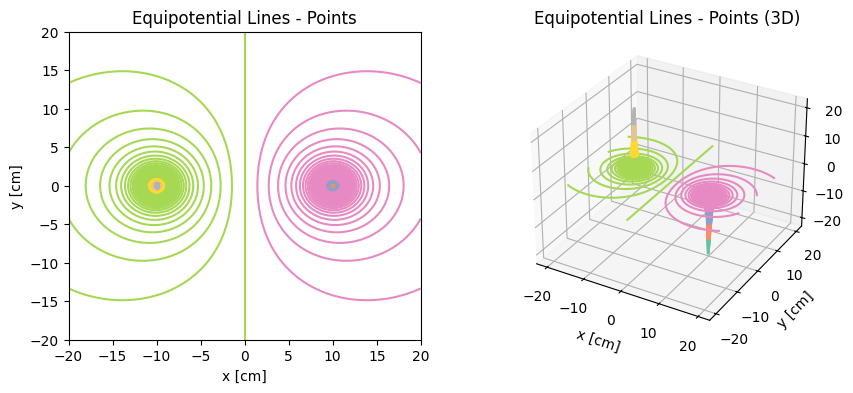

In [12]:
ax, ax2D, fig = Plot3D(x, y, z, 350, title="Equipotential Lines - Points");
scatteredPoints, scatteredPotentials = GetData("Data/data1.csv");

#ax2D.scatter(scatteredPoints[:, 0], scatteredPoints[:, 1], scatteredPotentials, c='grey', zorder=1);

fig.savefig("Plots/Plot1.png");

#### Equipotential lines from two charged bars.

In [13]:
# Calculating charge along two metal bars.
barPositions = chargedPoints;
graphSize = end - start;
barSize = 10;

# Calculating point-like charges in bars.
barPoints, barCharges = GenerateCharges(barPositions, charges, [Bar, Bar], barSize, barSize / graphSize * numPoints);

x, y, z = CalculatePotentialPoints(start, end, numPoints, barPoints, barCharges); 

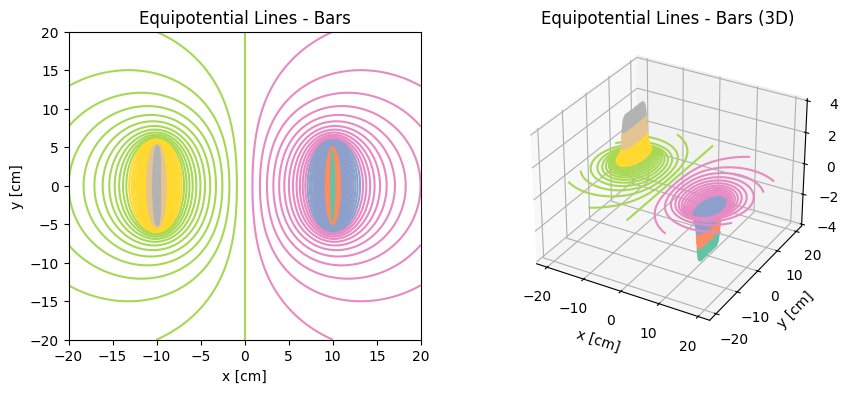

In [14]:
# Plotting points from bars
scatteredPoints, scatteredPotentials = GetData("Data/data2.csv");

ax, ax2D, fig = Plot3D(x, y, z, 100, title="Equipotential Lines - Bars");

#ax2D.scatter(scatteredPoints[:, 0], scatteredPoints[:, 1], scatteredPotentials, c='grey', zorder=1);

fig.savefig("Plots/Plot2.png");

#### Equipotential lines from two bars and a circle on the middle.

In [15]:
# Setting circle position and charge.
circlePos = [[0, 0], [0, 0]]; 
circObjCharges = -np.array(charges) * 0.5;
circSize = 2 * radius;

# Setting bar positions and charges.
barPositions = chargedPoints;
barObjCharges = charges;
barSize = 10;

# Calculating point-like charges in bars.
circlePoints, circleCharges = GenerateCharges(circlePos, circObjCharges, [CircBot, CircTop], circSize, circSize / graphSize * numPoints);
barPoints, barCharges = GenerateCharges(barPositions, barObjCharges, [Bar, Bar], barSize, barSize / graphSize * numPoints);

allPoints  = np.concatenate((circlePoints, barPoints));
allCharges = np.concatenate((circleCharges, barCharges));

x, y, z = CalculatePotentialPoints(start, end, numPoints, allPoints, allCharges); 

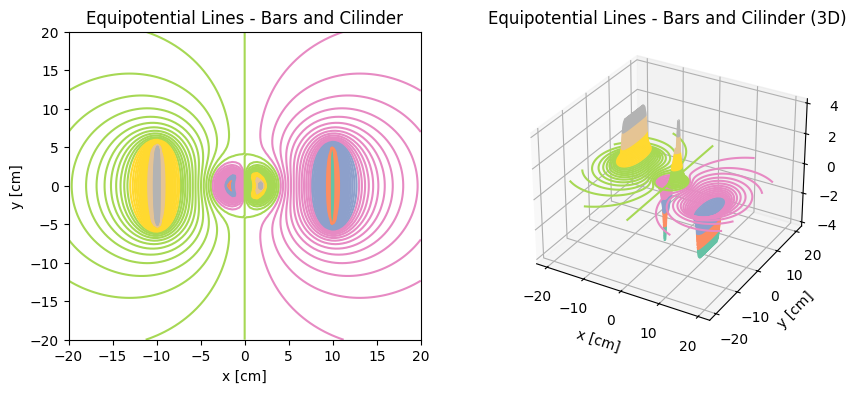

In [16]:
# Plotting points from bars and circle.
scatteredPoints, scatteredPotentials = GetData("Data/data3.csv");
ax, ax2D, fig = Plot3D(x, y, z, 120, title="Equipotential Lines - Bars and Cilinder");

#ax2D.scatter(scatteredPoints[:, 0], scatteredPoints[:, 1], scatteredPotentials, c='grey', zorder=1);

fig.savefig("Plots/Plot3.png");